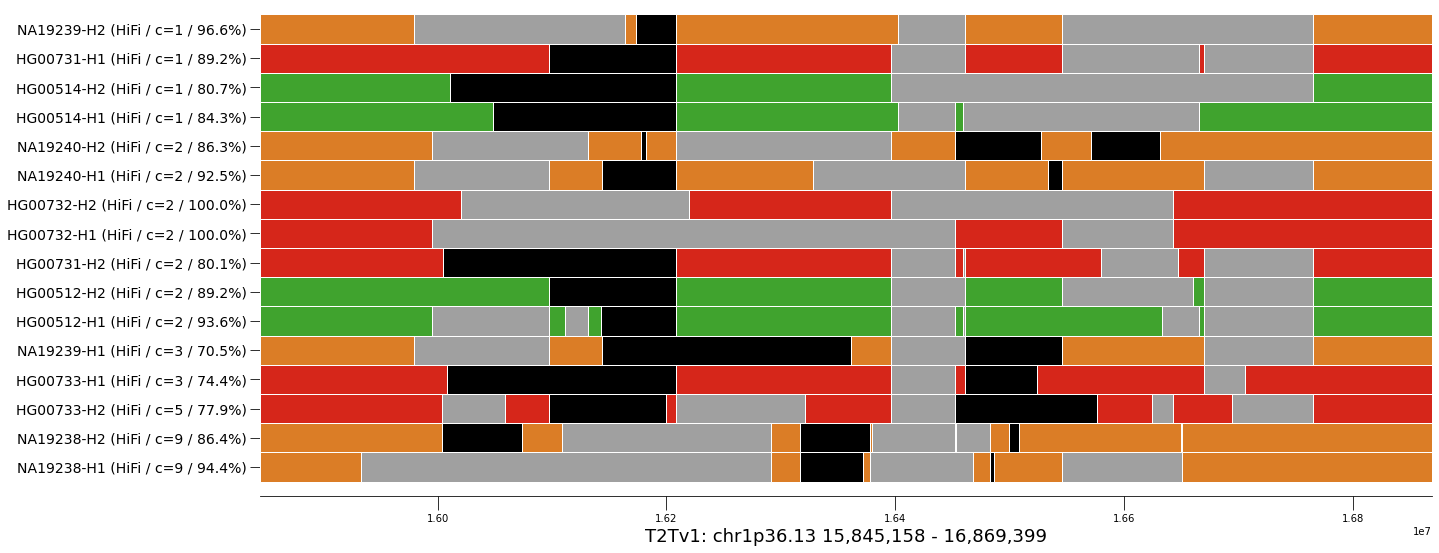

In [11]:
import pandas as pd
import os
import importlib
import re

import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

def rgb_rel(rgb):
    return tuple([round(x/255, 3) for x in rgb])

def rel_rgb(rgb):
    return rgb_rel(rgb)

# color definitions
white = (1, 1, 1)
light_blue = rel_rgb([50, 150, 255])
dark_blue = rel_rgb([50, 50, 255])

mustard = rgb_rel([220, 200, 0])
medium_grey = rgb_rel([160, 160, 160])
purple = rgb_rel([150, 0, 150])
red = rgb_rel([255, 0, 0])
light_yellow = rgb_rel([255, 255, 150])
light_orange = rgb_rel([255, 180, 100])
red_hifi = red
red_clr = rgb_rel([155, 0, 0])

all60 = rel_rgb([0,109,44])  # darkest shade
any60 = rel_rgb([49,163,84])
any50 = rel_rgb([116,196,118])
any40 = rel_rgb([186,228,179])
any20 = rel_rgb([237,248,233])  # lightest shade

region_colors = {
    'Gap': medium_grey,
    'Variation': mustard,
    'Unknown': purple,
    'SD_98': light_blue,
    'SD_99': dark_blue,
    'UAB': red,
    'LCaln': light_orange
}


def load_cytogenetic_bands():
    # http://circos.ca/tutorials/lessons/2d_tracks/connectors/configuration
    gie_stain_rgb = {
        'gpos100': (0,0,0),
        'gpos': (0,0,0),
        'gpos75': (130,130,130),
        'gpos66': (160,160,160),
        'gpos50': (200,200,200),
        'gpos33': (210,210,210),
        'gpos25': (200,200,200),
        'gvar': (220,220,220),
        'gneg': (255,255,255),
        'acen': (217,47,39),
        'stalk': (100,127,164)
    }
    gie_stain_frac_rgb = {}
    for k, v in gie_stain_rgb.items():
        gie_stain_frac_rgb[k] = rgb_rel(v)
        path = '/home/local/work/code/github/project-diploid-assembly/annotation/grch38/known_regions'
        cytobands = 'ucsc_cytoband.bed'

        df = pd.read_csv(
            os.path.join(path, cytobands),
            header=0,
            names=['chrom', 'start', 'end', 'name', 'gieStain'],
            sep='\t'
        )
        df['length'] = df['end'] - df['start']
        df['color'] = df['gieStain'].apply(lambda x: rel_rgb(gie_stain_rgb[x]))

    return df

# 3q29, 1p3613
locus_name = '1p36.13'
# hg38, t2t
ref_genome = 't2t'

if ref_genome == 'hg38':
    aln_file = 'roi_3q29_1p3613_blocks.tsv'
    aln_file = 'MAPQ-ALL_roi-hg38_blocks.tsv'
else:
    aln_file = 'roi-t2t_1p3613_blocks.tsv'
    aln_file = 'MAPQ-ALL_roi-t2t_blocks.tsv'
    
locus_info = {
    'hg38': {
        '3q29': {
            # chr3q29 195,607,154 - 196,027,006 ; previous coordinates used for HGSVC2
            'label': 'hg38: chr3q29 195,578,485 - 196,093,485',
            'left_bound': 195578485,
            'right_bound': 196093485
        },
        '1p36.13': {
            'label': 'hg38: chr1p36.13 16,403,455 - 17,058,790',
            'left_bound': 16403455,
            'right_bound': 17058790
        }
    },
    't2t': {
        '3q29': {
            'label': 'T2Tv1: chr3q29 198,286,051 - 198,814,309',
            'left_bound': 198286051,
            'right_bound': 198814309
        },
        '1p36.13': {
            'label': 'T2Tv1: chr1p36.13 15,845,158 - 16,869,399',
            'left_bound': 15845158,
            'right_bound': 16869399
        }
    }
}

aln_path = os.path.join('/home/local/work/data/hgsvc/roi/', aln_file)
aln_path = os.path.join('/home/local/work/data/sig_complex-regions/contig-ref_aln', aln_file)
aligns = pd.read_csv(aln_path, sep='\t', header=0)
aligns = aligns.loc[aligns['roi'] == locus_name, :].copy()

# Figure stuff
width = 21
height = 9

fig, ax = plt.subplots(figsize=(width, height))

y_start = 0
y_labels = []
y_labels_pos = []
legend_patches = []
max_plot = 0

for num in reversed(sorted(set(aligns['contigs']))):
    sub = aligns.loc[aligns['contigs'] == num, :].copy()
    sub.sort_values('block_start', inplace=True)
    
    for (sample, tech, hap), rows in sub.groupby(['sample', 'platform', 'hap']):
        
        contig = rows['contigs'].values[0]
        cov_pct = round(rows['cov_pct'].values[0] * 100, 1)
        
        y_labels.append('{}-{} ({} / c={} / {}%)'.format(sample, hap, tech, contig, cov_pct))
        y_labels_pos.append(y_start + 0.5)
        
        row_blocks = []
        row_colors = []
        
        for idx, row in rows.iterrows():
            row_blocks.append(
                (
                    row['block_start'],
                    row['block_length']
                )
            )
            rgb = row['block_color'].strip('()').split(',')
            rgb = tuple(map(float, rgb))
            row_colors.append(rgb)

        ax.broken_barh(
            row_blocks,
            (y_start, 1),
            edgecolor='white',
            facecolors=row_colors,
            zorder=10
        )
        y_start += 1

_ = ax.set_yticks(y_labels_pos)
_ = ax.set_yticklabels(y_labels, fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', length=10)
ax.tick_params(axis='x', which='major', length=10, size=14)


label = locus_info[ref_genome][locus_name]['label']
left = locus_info[ref_genome][locus_name]['left_bound']
right = locus_info[ref_genome][locus_name]['right_bound']

_ = ax.set_xlabel(label, fontsize=18)
_ = ax.set_xlim(left, right)
_ = ax.set_ylim(-0.5, y_start + 0.25)


#out_path = '/home/local/work/data/hgsvc/figSX_panels/ideograms'

#fig.savefig(
#    os.path.join(out_path, 'chr6_HLA_lowres.png'), dpi=150, bbox_inches='tight'
#)

# fig.savefig(
#     os.path.join(out_path, 'chr16p.svg'), bbox_inches='tight'
# )